In [ ]:
pip install networkx matplotlib

In [ ]:
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt

In [ ]:
def show_graph(G):
  communities = community.girvan_newman(G)
  top_level_communities = next(communities)
  sorted_communities = sorted(map(sorted, top_level_communities))

  community_map = {}
  for community_id, community_nodes in enumerate(sorted_communities):
      for node in community_nodes:
          community_map[node] = community_id

  plt.figure(figsize=(10, 8))
  pos = nx.spring_layout(G)
  colors = [community_map[node] for node in G.nodes()]
  nx.draw_networkx(G, pos, node_color=colors, with_labels=True, cmap=plt.cm.tab20)
  plt.show()

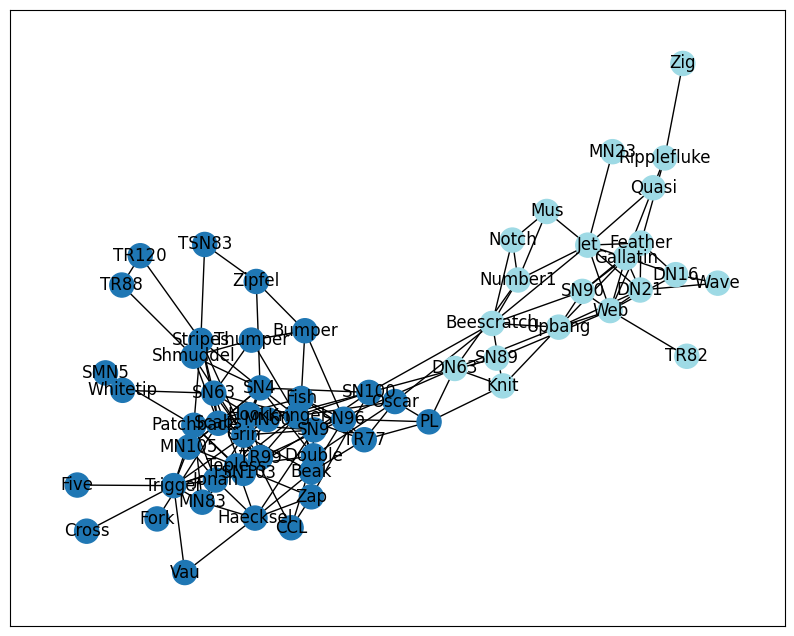

In [ ]:
G = nx.read_gml('graphs/dolphins.gml')
show_graph(G)

In [ ]:
def my_read_gml(file_path):
    G = nx.Graph()

    with open(file_path, 'r') as file:
        lines = file.readlines()

    is_node = False
    is_edge = False
    nodes = {}
    edges = set()
    node_id = None

    for line in lines:
        if line.strip().startswith("node"):
            is_node = True
            is_edge = False
            node_id = None
        elif line.strip().startswith("edge"):
            is_node = False
            is_edge = True
            source, target = None, None
        elif is_node:
            if line.strip().startswith("id"):
                node_id = int(line.strip().split()[1])
                nodes[node_id] = {}
        elif is_edge:
            if line.strip().startswith("source"):
                source = int(line.strip().split()[1])
            elif line.strip().startswith("target"):
                target = int(line.strip().split()[1])
            elif line.strip() == "]":
                if source is not None and target is not None:
                    edges.add((source, target))
            else:
                continue

    if min(nodes.keys()) == 0:
        nodes = {k + 1: v for k, v in nodes.items()}
        edges = {(k + 1, v + 1) for k, v in edges}

    G.add_nodes_from(nodes.keys())
    G.add_edges_from(edges)

    return G

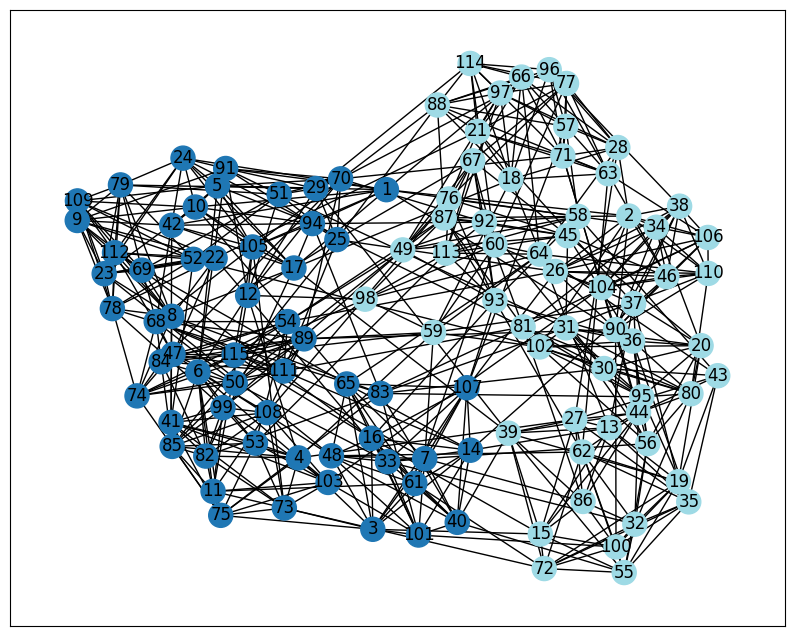

In [ ]:
G = my_read_gml("graphs/football.gml")
show_graph(G)

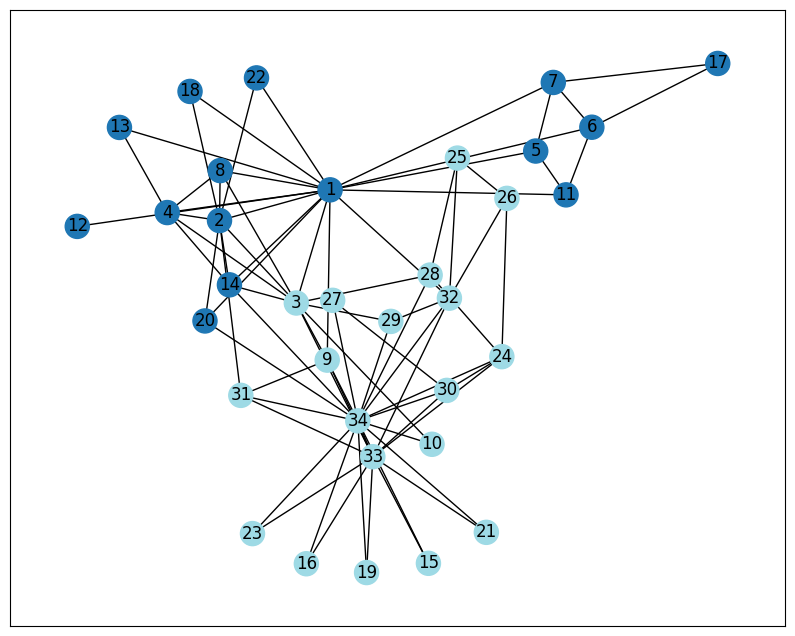

In [ ]:
G = my_read_gml("graphs/karate.gml")
show_graph(G)

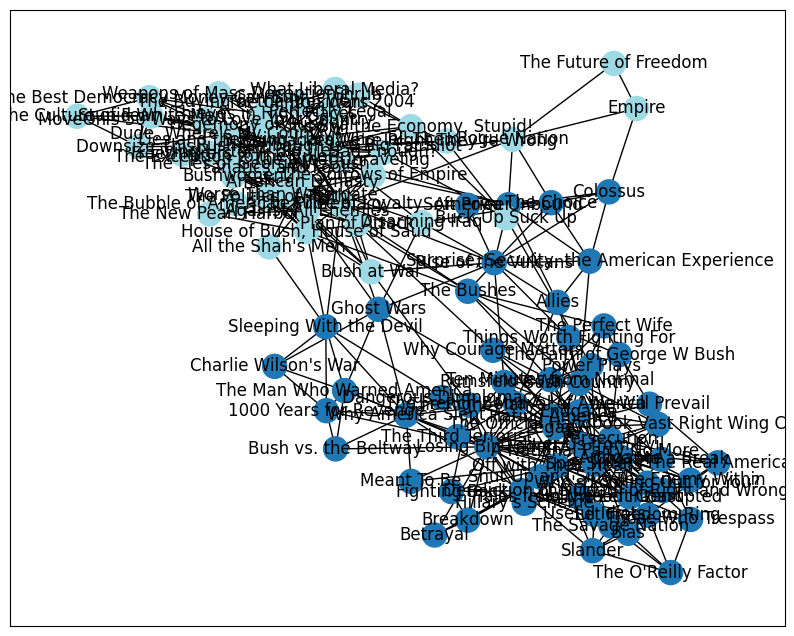

In [ ]:
G = nx.read_gml("graphs/krebs.gml")
show_graph(G)

In [ ]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import modularity

class Chromosome:
    def __init__(self, representation):
        self.representation = representation
        self.fitness = 0.0

    def evaluate(self, G):
        if is_valid_partition(G, self.representation):
            self.fitness = modularity(G, self.representation)
        else:
            self.fitness = float('-inf')

def is_valid_partition(G, partition):
    nodes = set(G.nodes())
    partition_nodes = set(node for community in partition for node in community)
    return nodes == partition_nodes

def initial_random_community_structure(G):
    nodes = list(G.nodes())
    random.shuffle(nodes)
    num_communities = random.randint(2, len(nodes) // 2)
    communities = [[] for _ in range(num_communities)]
    for i, node in enumerate(nodes):
        communities[i % num_communities].append(node)
    return communities

def selection(population):
    population.sort(key=lambda chromo: chromo.fitness, reverse=True)
    selected = population[:len(population)//2]
    if not selected:
        selected = population[:2]
    return selected

def crossover(parents, crossover_rate):
    offspring = []
    for i in range(len(parents)//2):
        parent1 = parents[2*i]
        parent2 = parents[2*i+1]
        if random.random() < crossover_rate:
            cut1 = random.randint(1, len(parent1.representation) - 1)
            cut2 = random.randint(1, len(parent2.representation) - 1)
            child1_repr = parent1.representation[:cut1] + parent2.representation[cut2:]
            child2_repr = parent2.representation[:cut2] + parent1.representation[cut1:]

            child1_repr = fix_communities(child1_repr, len(G))
            child2_repr = fix_communities(child2_repr, len(G))

            offspring.append(Chromosome(child1_repr))
            offspring.append(Chromosome(child2_repr))
        else:
            offspring.append(parent1)
            offspring.append(parent2)
    return offspring

def fix_communities(communities, num_nodes):
    node_set = set()
    fixed_communities = []
    for community in communities:
        fixed_community = []
        for node in community:
            if node not in node_set:
                fixed_community.append(node)
                node_set.add(node)
        if fixed_community:
            fixed_communities.append(fixed_community)

    missing_nodes = set(range(num_nodes)) - node_set
    for node in missing_nodes:
        fixed_communities.append([node])

    return fixed_communities

def mutate(offspring, mutation_rate):
    for child in offspring:
        if random.random() < mutation_rate:
            community = random.choice(child.representation)
            if community:
                node = random.choice(community)
                community.remove(node)
                new_community = random.choice(child.representation)
                new_community.append(node)
    return offspring

def my_show_graph(G):
  node_mapping = {node: i for i, node in enumerate(G.nodes())}
  G = nx.relabel_nodes(G, node_mapping)

  pop_size = 10
  num_generations = 50
  crossover_rate = 0.8
  mutation_rate = 0.1

  population = [Chromosome(initial_random_community_structure(G)) for _ in range(pop_size)]

  best_solution = None
  for generation in range(num_generations):
      for chromosome in population:
          chromosome.evaluate(G)

      for i, chromosome in enumerate(population):
          print(f"Generation {generation+1}, Chromosome {i+1}, Fitness: {chromosome.fitness}")

      population = [chromo for chromo in population if chromo.fitness != float('-inf')]
      if not population:
          print(f"All chromosomes invalid in generation {generation+1}. Reinitializing population.")
          population = [Chromosome(initial_random_community_structure(G)) for _ in range(pop_size)]
          continue

      selected_parents = selection(population)

      if len(selected_parents) < 2:
          selected_parents = population[:2]

      offspring = crossover(selected_parents, crossover_rate)

      mutated_offspring = mutate(offspring, mutation_rate)

      if not mutated_offspring:
          mutated_offspring = selected_parents

      population = mutated_offspring

      if population:
          best_solution = max(population, key=lambda chromo: chromo.fitness)
          print(f"Generation {generation+1}: Best fitness = {best_solution.fitness}")
      else:
          print(f"All chromosomes invalid after mutation in generation {generation+1}. Reinitializing population.")
          population = [Chromosome(initial_random_community_structure(G)) for _ in range(pop_size)]

  best_community_structure = best_solution.representation
  print("Best community structure:", best_community_structure)

  community_map = {}
  for community_id, community_nodes in enumerate(best_community_structure):
      for node in community_nodes:
          community_map[node] = community_id

  reverse_node_mapping = {v: k for k, v in node_mapping.items()}
  community_map = {reverse_node_mapping[node]: community_id for node, community_id in community_map.items()}

  for node in G.nodes():
      if node not in community_map:
          community_map[node] = -1

  plt.figure(figsize=(10, 8))
  pos = nx.spring_layout(G)
  colors = [community_map[node] for node in G.nodes()]
  nx.draw_networkx(G, pos, node_color=colors, with_labels=True, cmap=plt.cm.tab20)
  plt.show()


Generation 1, Chromosome 1, Fitness: -0.022427910288358853
Generation 1, Chromosome 2, Fitness: -0.0092559629761481
Generation 1, Chromosome 3, Fitness: -0.026007673747082814
Generation 1, Chromosome 4, Fitness: -0.03581741228590642
Generation 1, Chromosome 5, Fitness: -0.013607056682884382
Generation 1, Chromosome 6, Fitness: 0.0155650488509157
Generation 1, Chromosome 7, Fitness: -0.012895059530872999
Generation 1, Chromosome 8, Fitness: -0.038032514536608525
Generation 1, Chromosome 9, Fitness: 0.0002966654800047319
Generation 1, Chromosome 10, Fitness: 0.016751710770934687
Generation 1: Best fitness = 0.0002966654800047319
Generation 2, Chromosome 1, Fitness: 0.016989043154938488
Generation 2, Chromosome 2, Fitness: -0.01772081800561688
Generation 2, Chromosome 3, Fitness: 0.0002966654800047319
Generation 2, Chromosome 4, Fitness: -0.0092559629761481
Generation 2: Best fitness = 0.0
Generation 3, Chromosome 1, Fitness: -0.0006328863573434639
Generation 3, Chromosome 2, Fitness: -0.

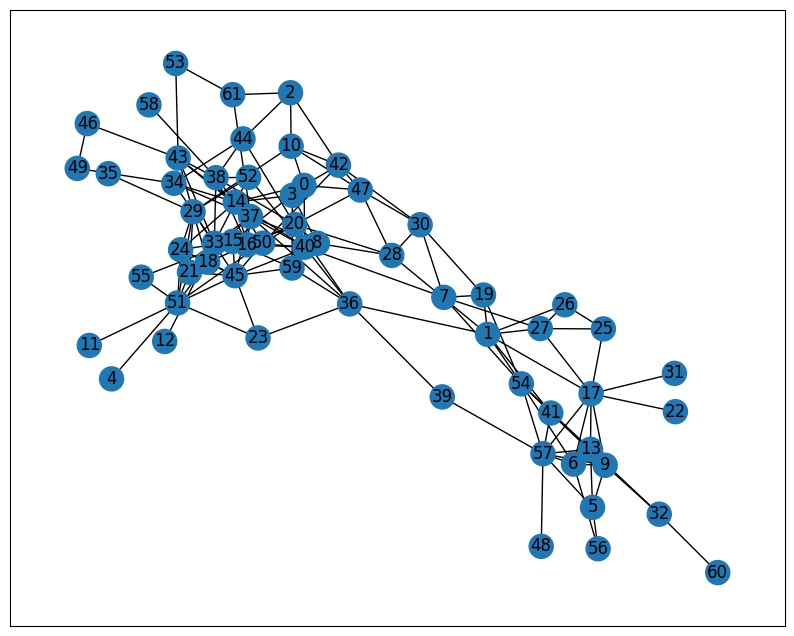

In [ ]:
G = nx.read_gml("graphs/dolphins.gml")
my_show_graph(G)

Generation 1, Chromosome 1, Fitness: -0.00504831425689719
Generation 1, Chromosome 2, Fitness: -0.011698676580558795
Generation 1, Chromosome 3, Fitness: 0.012427847959783795
Generation 1, Chromosome 4, Fitness: -0.020730821329061205
Generation 1, Chromosome 5, Fitness: -0.0006905838427331765
Generation 1, Chromosome 6, Fitness: -0.02035426019708917
Generation 1, Chromosome 7, Fitness: 0.02012805739696462
Generation 1, Chromosome 8, Fitness: -0.009246372106267413
Generation 1, Chromosome 9, Fitness: -0.01124494037560309
Generation 1, Chromosome 10, Fitness: -0.009870425713669832
Generation 1: Best fitness = 0.0
Generation 2, Chromosome 1, Fitness: 0.01145783712866149
Generation 2, Chromosome 2, Fitness: 0.00352610247252965
Generation 2, Chromosome 3, Fitness: -0.004578610795462113
Generation 2, Chromosome 4, Fitness: -0.004140841846985779
Generation 2: Best fitness = 0.0
Generation 3, Chromosome 1, Fitness: 0.011750570164116783
Generation 3, Chromosome 2, Fitness: 0.00352610247252965
G

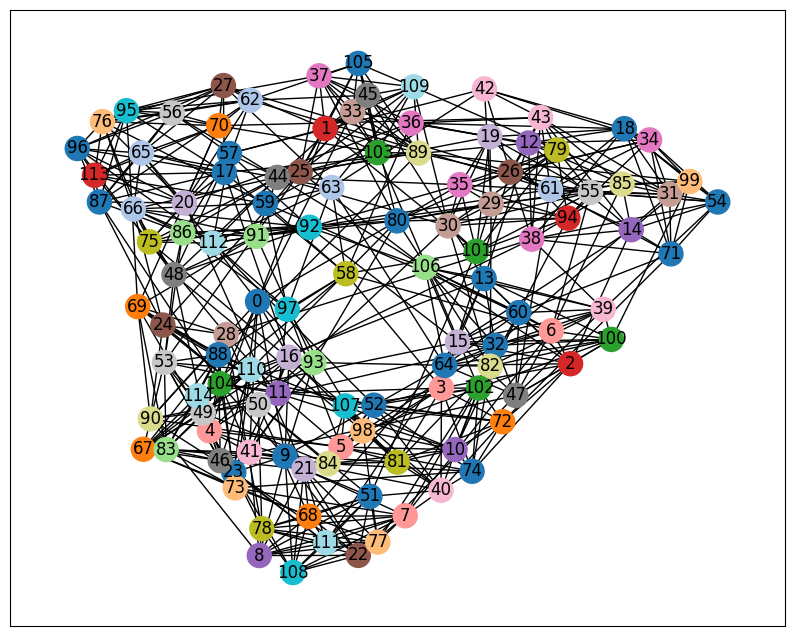

In [ ]:
G = my_read_gml("graphs/football.gml")
my_show_graph(G)

Generation 1, Chromosome 1, Fitness: -0.0678829717291256
Generation 1, Chromosome 2, Fitness: -0.03698224852071007
Generation 1, Chromosome 3, Fitness: -0.04257067718606181
Generation 1, Chromosome 4, Fitness: -0.05876068376068377
Generation 1, Chromosome 5, Fitness: -0.019477317554240647
Generation 1, Chromosome 6, Fitness: -0.021449704142011836
Generation 1, Chromosome 7, Fitness: -0.01084812623274163
Generation 1, Chromosome 8, Fitness: -0.061801446416831045
Generation 1, Chromosome 9, Fitness: -0.031147271531886917
Generation 1, Chromosome 10, Fitness: -0.02695595003287312
Generation 1: Best fitness = 0.0
Generation 2, Chromosome 1, Fitness: 0.002136752136752122
Generation 2, Chromosome 2, Fitness: -0.043145956607495074
Generation 2, Chromosome 3, Fitness: -0.05473372781065091
Generation 2, Chromosome 4, Fitness: -0.023093359631821173
Generation 2: Best fitness = 0.0
Generation 3, Chromosome 1, Fitness: -0.036160420775805405
Generation 3, Chromosome 2, Fitness: -0.00427350427350428

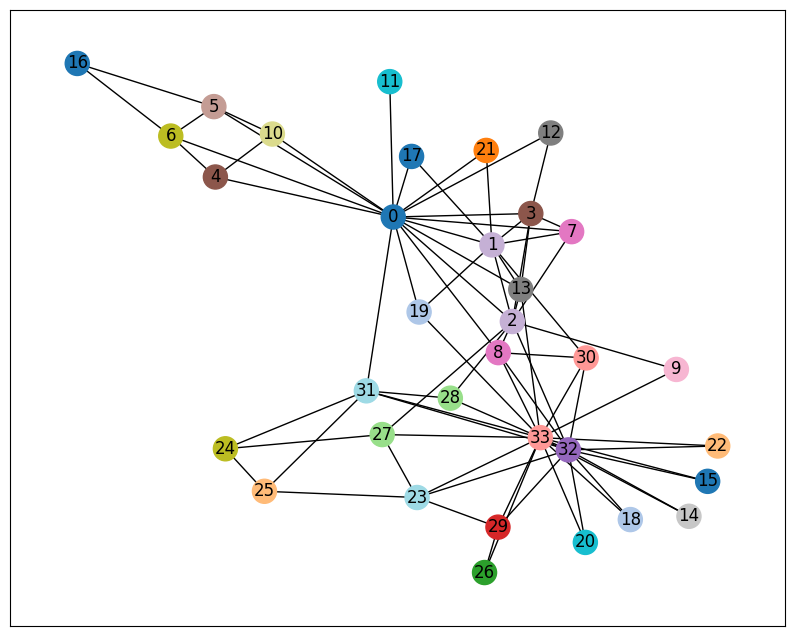

In [ ]:
G = my_read_gml("graphs/karate.gml")
my_show_graph(G)

Generation 1, Chromosome 1, Fitness: -0.010162946508913463
Generation 1, Chromosome 2, Fitness: -0.010044683028162128
Generation 1, Chromosome 3, Fitness: -0.009898139149839828
Generation 1, Chromosome 4, Fitness: 0.010157804618446037
Generation 1, Chromosome 5, Fitness: -0.015605637568708511
Generation 1, Chromosome 6, Fitness: 0.005023626986697933
Generation 1, Chromosome 7, Fitness: -0.02539836796396562
Generation 1, Chromosome 8, Fitness: -0.0184131097639358
Generation 1, Chromosome 9, Fitness: -0.02053671052699235
Generation 1, Chromosome 10, Fitness: -0.01384196913837341
Generation 1: Best fitness = 0.0
Generation 2, Chromosome 1, Fitness: -0.002609509412230503
Generation 2, Chromosome 2, Fitness: 0.012348249957579409
Generation 2, Chromosome 3, Fitness: -0.009219409608136525
Generation 2, Chromosome 4, Fitness: -0.014176192018757616
Generation 2: Best fitness = 0.012348249957579409
Generation 3, Chromosome 1, Fitness: 0.012348249957579409
Generation 3, Chromosome 2, Fitness: -0.

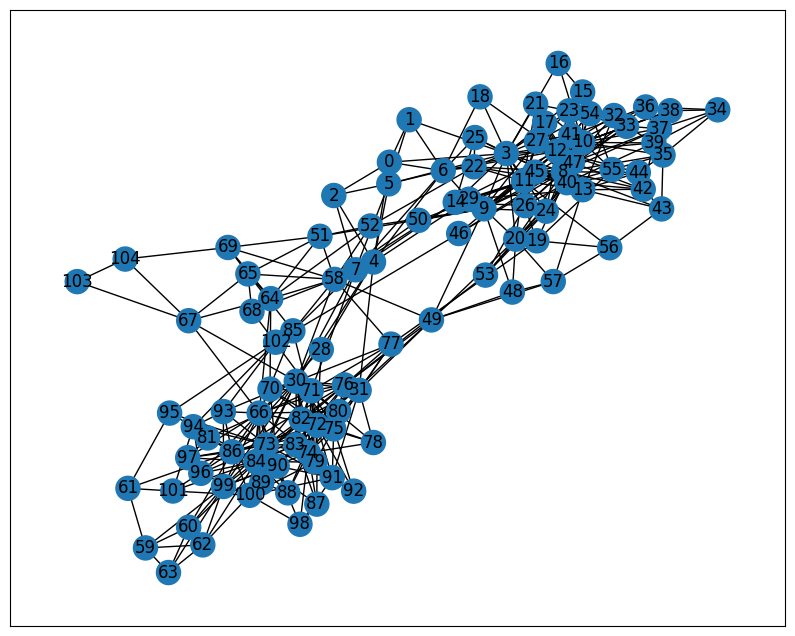

In [ ]:
G = nx.read_gml("graphs/krebs.gml")
my_show_graph(G)

In [ ]:
def read_edge_list_network(file_path):
    G = nx.Graph()
    with open(file_path, 'r') as file:
        lines = file.readlines()
    for line in lines:
        if not line.strip() or line.strip().startswith('%'):
            continue
        try:
            source, target = map(int, line.strip().split()[:2])
            G.add_edge(source, target)
        except ValueError:
            print(f"Ignorând linia: {line.strip()}. Nu poate fi parsată corect.")
            continue

    nodes = G.nodes()
    edges = G.edges()
    if min(nodes) == 0:
        mapping = {k: k + 1 for k in nodes}
        G = nx.relabel_nodes(G, mapping)
        edges = {(k + 1, v + 1) for k, v in edges}
        G.add_edges_from(edges)

    return G